Take early V1 fMRI with early layers, first 2.
Then take a later one that doesn't show effect.
So, plot of (1,3) 
the partial shuffling will show a gradient in two but not in the third.

Shuffle levels: 0% 20% 40% 60% 80% 100%.

In [2]:
import sys
sys.path.append("/home/amurphy3/code/Github/cka_alignment/src")

import numpy as np 
import pandas as pd
import pickle

from itertools import chain
from metrics import cka, gram_linear, RV2
from pathlib import Path

resnet_activations_path = Path('/home/amurphy3/data/THINGS/model_activations/val_fMRI/resnet18')
fMRI_folder = Path('/home/amurphy3/data/THINGS/fMRI/fMRI_ROIs_val_THINGS')
assert resnet_activations_path.exists()
assert fMRI_folder.exists()

layer_names_resnet18 = [ 'conv1', 'maxpool',
                        'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2',
                        'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2',
                        'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2',
                        'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2',
                        'avgpool', 'fc']

In [3]:
sub01_V1 = np.load(fMRI_folder / 'fMRI_val_sub01_subset_V1.npy')
sub02_V1 = np.load(fMRI_folder / 'fMRI_val_sub02_subset_V1.npy')
sub03_V1 = np.load(fMRI_folder / 'fMRI_val_sub03_subset_V1.npy')

sub01_PPA = np.load(fMRI_folder / 'fMRI_val_sub01_subset_lPPA.npy')
sub02_PPA = np.load(fMRI_folder / 'fMRI_val_sub02_subset_lPPA.npy')
sub03_PPA = np.load(fMRI_folder / 'fMRI_val_sub03_subset_lPPA.npy')

In [8]:
import random

def partial_shuffle(a, part=0.5):
    # which characters are to be shuffled:
    idx_todo = random.sample(range(len(a)), int(len(a) * part))

    # what are the new positions of these to-be-shuffled characters:
    idx_target = idx_todo[:]
    random.shuffle(idx_target)

    # map all "normal" character positions {0:0, 1:1, 2:2, ...}
    mapper = dict((i, i) for i in range(len(a)))

    # update with all shuffles in the string: {old_pos:new_pos, old_pos:new_pos, ...}
    mapper.update(zip(idx_todo, idx_target))

    # use mapper to modify the string:
    return [mapper[i] for i in range(len(a))]



In [4]:
layer_names_resnet18[:3]

['conv1', 'maxpool', 'layer1.0.conv1']

In [7]:
resnet_conv1 = np.load(resnet_activations_path / 'conv1' / 'features.npy')
resnet_maxpool = np.load(resnet_activations_path / 'maxpool' / 'features.npy')

In [5]:
seeds = [3254,25334,32453,253253,75434]

In [6]:
from collections import defaultdict 

In [9]:
def get_alignment_scores_partial_shuffle(model_layers, model_act_path, roi, seeds):
    """ This function returns the CKA (biased), CKA (debiased) and RV2 scores for 
        a specific set of biological responses and model activations for the same stimuli """
    
    # subid = "01"
    
    results = defaultdict(list)
    results['biased'] = defaultdict(list)
    results['debiased'] = defaultdict(list)
    
    for i, seed in enumerate(seeds):
        np.random.seed(seed)
        print(f'Seed: {seed}')

        # Random
        for sub in [1, 2, 3]:
            brain_data =  np.load(fMRI_folder / f'fMRI_val_sub0{sub}_subset_{roi}.npy')
            
            for j, layer_name in enumerate(model_layers):
                X = np.load(model_act_path / layer_name / 'features.npy')
                Y = brain_data

                for shuffle_percent in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:

                    idx = list(range(Y.shape[0]))
                    idx_shuffled = partial_shuffle(idx, part=shuffle_percent)
                    Y = Y[idx_shuffled]
                    cka_biased = cka(gram_linear(X), gram_linear(Y))
                    cka_debiased = cka(gram_linear(X), gram_linear(Y), debiased=True)

                    res_string = f'roi-{roi}_layer-{layer_name}_shuffle-{shuffle_percent}'
                    results['biased'][res_string].append(cka_biased)
                    results['debiased'][res_string].append(cka_debiased)

                    print(f"sp:{shuffle_percent}, layer: {layer_name}, CKA (biased): {cka_biased:.5f}, CKA (unbiased): {cka_debiased:.5f}")
            
    return results

In [23]:
results = get_alignment_scores_partial_shuffle(model_layers=layer_names_resnet18[:3],
                     model_act_path=resnet_activations_path,
                    roi='V1', seeds=seeds[:3])

Seed: 3254
sp:0.0, layer: conv1, CKA (biased): 0.08564, CKA (unbiased): 0.04018
sp:0.2, layer: conv1, CKA (biased): 0.06866, CKA (unbiased): 0.02223
sp:0.4, layer: conv1, CKA (biased): 0.05037, CKA (unbiased): 0.00293
sp:0.6, layer: conv1, CKA (biased): 0.04837, CKA (unbiased): 0.00091
sp:0.8, layer: conv1, CKA (biased): 0.04934, CKA (unbiased): 0.00212
sp:1.0, layer: conv1, CKA (biased): 0.04553, CKA (unbiased): -0.00233
sp:0.0, layer: maxpool, CKA (biased): 0.11538, CKA (unbiased): 0.06322
sp:0.2, layer: maxpool, CKA (biased): 0.09260, CKA (unbiased): 0.03869
sp:0.4, layer: maxpool, CKA (biased): 0.07716, CKA (unbiased): 0.02218
sp:0.6, layer: maxpool, CKA (biased): 0.05988, CKA (unbiased): 0.00299
sp:0.8, layer: maxpool, CKA (biased): 0.05552, CKA (unbiased): -0.00150
sp:1.0, layer: maxpool, CKA (biased): 0.05890, CKA (unbiased): 0.00230
sp:0.0, layer: layer1.0.conv1, CKA (biased): 0.11856, CKA (unbiased): 0.05991
sp:0.2, layer: layer1.0.conv1, CKA (biased): 0.09490, CKA (unbiased):

In [24]:
# conv1 

sp0_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-0.0'])
sp20_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-0.2'])
sp40_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-0.4'])
sp60_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-0.6'])
sp80_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-0.8'])
sp100_m_b = np.mean(results['biased']['roi-V1_layer-conv1_shuffle-1.0'])

sp0_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-0.0'])
sp20_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-0.2'])
sp40_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-0.4'])
sp60_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-0.6'])
sp80_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-0.8'])
sp100_m_d = np.mean(results['debiased']['roi-V1_layer-conv1_shuffle-1.0'])

sp0_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-0.0'])
sp20_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-0.2'])
sp40_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-0.4'])
sp60_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-0.6'])
sp80_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-0.8'])
sp100_s_b = np.std(results['biased']['roi-V1_layer-conv1_shuffle-1.0'])

sp0_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-0.0'])
sp20_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-0.2'])
sp40_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-0.4'])
sp60_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-0.6'])
sp80_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-0.8'])
sp100_s_d = np.std(results['debiased']['roi-V1_layer-conv1_shuffle-1.0'])

conv1_list_V1 = [sp0_m_b, sp0_m_d, sp20_m_b, sp20_m_d, sp40_m_b, sp40_m_d, sp60_m_b, sp60_m_d,sp80_m_b, sp80_m_d,sp100_m_b, sp100_m_d]

 # maxpool 

sp0_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-0.0'])
sp20_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-0.2'])
sp40_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-0.4'])
sp60_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-0.6'])
sp80_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-0.8'])
sp100_m_b = np.mean(results['biased']['roi-V1_layer-maxpool_shuffle-1.0'])

sp0_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-0.0'])
sp20_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-0.2'])
sp40_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-0.4'])
sp60_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-0.6'])
sp80_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-0.8'])
sp100_m_d = np.mean(results['debiased']['roi-V1_layer-maxpool_shuffle-1.0'])

sp0_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-0.0'])
sp20_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-0.2'])
sp40_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-0.4'])
sp60_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-0.6'])
sp80_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-0.8'])
sp100_s_b = np.std(results['biased']['roi-V1_layer-maxpool_shuffle-1.0'])

sp0_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-0.0'])
sp20_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-0.2'])
sp40_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-0.4'])
sp60_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-0.6'])
sp80_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-0.8'])
sp100_s_d = np.std(results['debiased']['roi-V1_layer-maxpool_shuffle-1.0'])

maxpool_list_V1 = [sp0_m_b, sp0_m_d, sp20_m_b, sp20_m_d, sp40_m_b, sp40_m_d, sp60_m_b, sp60_m_d,sp80_m_b, sp80_m_d,sp100_m_b, sp100_m_d]

 # layer1.0.conv1

sp0_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
sp20_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
sp40_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
sp60_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
sp80_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
sp100_m_b = np.mean(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

sp0_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
sp20_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
sp40_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
sp60_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
sp80_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
sp100_m_d = np.mean(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

sp0_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
sp20_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
sp40_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
sp60_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
sp80_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
sp100_s_b = np.std(results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

sp0_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
sp20_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
sp40_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
sp60_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
sp80_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
sp100_s_d = np.std(results['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

layer1_0_conv1_list_V1 = [sp0_m_b, sp0_m_d, sp20_m_b, sp20_m_d, sp40_m_b, sp40_m_d, sp60_m_b, sp60_m_d,sp80_m_b, sp80_m_d,sp100_m_b, sp100_m_d]

In [40]:
# conv1 

sp0_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-0.0'])
sp20_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-0.2'])
sp40_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-0.4'])
sp60_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-0.6'])
sp80_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-0.8'])
sp100_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-conv1_shuffle-1.0'])

sp0_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-0.0'])
sp20_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-0.2'])
sp40_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-0.4'])
sp60_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-0.6'])
sp80_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-0.8'])
sp100_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-conv1_shuffle-1.0'])

conv1_list_lPPA = [sp0_m_b_lPPA, sp0_m_d_lPPA, sp20_m_b_lPPA, sp20_m_d_lPPA, sp40_m_b_lPPA, sp40_m_d_lPPA, sp60_m_b_lPPA, sp60_m_d_lPPA,sp80_m_b_lPPA, sp80_m_d_lPPA,sp100_m_b_lPPA, sp100_m_d_lPPA]

#sp0_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
#sp20_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
#sp40_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
#sp60_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
#sp80_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
#sp100_s_b = np.std(results_lPPA['biased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

#sp0_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.0'])
#sp20_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.2'])
#sp40_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.4'])
#sp60_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.6'])
#sp80_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'])
#sp100_s_d = np.std(results_lPPA['debiased']['roi-V1_layer-layer1.0.conv1_shuffle-1.0'])

# maxpool 

sp0_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.0'])
sp20_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.2'])
sp40_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.4'])
sp60_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.6'])
sp80_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.8'])
sp100_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-1.0'])

sp0_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-0.0'])
sp20_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-0.2'])
sp40_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-0.4'])
sp60_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-0.6'])
sp80_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-0.8'])
sp100_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-maxpool_shuffle-1.0'])

maxpool_list_lPPA = [sp0_m_b_lPPA, sp0_m_d_lPPA, sp20_m_b_lPPA, sp20_m_d_lPPA, sp40_m_b_lPPA, sp40_m_d_lPPA, sp60_m_b_lPPA, sp60_m_d_lPPA,sp80_m_b_lPPA, sp80_m_d_lPPA,sp100_m_b_lPPA, sp100_m_d_lPPA]

# layer1.0.conv1

sp0_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.0'])
sp20_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.2'])
sp40_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.4'])
sp60_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.6'])
sp80_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.8'])
sp100_m_b_lPPA = np.mean(results_lPPA['biased']['roi-lPPA_layer-layer1.0.conv1_shuffle-1.0'])

sp0_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.0'])
sp20_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.2'])
sp40_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.4'])
sp60_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.6'])
sp80_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-0.8'])
sp100_m_d_lPPA = np.mean(results_lPPA['debiased']['roi-lPPA_layer-layer1.0.conv1_shuffle-1.0'])

layer1_0_conv1_list_lPPA = [sp0_m_b_lPPA, sp0_m_d_lPPA, sp20_m_b_lPPA, sp20_m_d_lPPA, sp40_m_b_lPPA, sp40_m_d_lPPA, sp60_m_b_lPPA, sp60_m_d_lPPA,sp80_m_b_lPPA, sp80_m_d_lPPA,sp100_m_b_lPPA, sp100_m_d_lPPA]

In [39]:
results_lPPA['biased']['roi-lPPA_layer-maxpool_shuffle-0.0']

[0.11790842,
 0.15689422,
 0.10963023,
 0.11790842,
 0.15689422,
 0.10963023,
 0.11790842,
 0.15689422,
 0.10963023]

In [36]:
maxpool_list_lPPA

[0.0023072674,
 0.0023072674,
 0.0019855925,
 0.0019855925,
 0.0016312553,
 0.0016312553,
 0.00018394663,
 0.00018394663,
 -0.0005958044,
 -0.0005958044,
 -0.00021666203,
 -0.00021666203]

In [12]:
results_lPPA = get_alignment_scores_partial_shuffle(model_layers=layer_names_resnet18[:3],
                     model_act_path=resnet_activations_path,
                    roi='lPPA', seeds=seeds[:3])

Seed: 3254
sp:0.0, layer: conv1, CKA (biased): 0.09910, CKA (unbiased): 0.00339
sp:0.2, layer: conv1, CKA (biased): 0.09846, CKA (unbiased): 0.00259
sp:0.4, layer: conv1, CKA (biased): 0.09974, CKA (unbiased): 0.00397
sp:0.6, layer: conv1, CKA (biased): 0.09674, CKA (unbiased): 0.00060
sp:0.8, layer: conv1, CKA (biased): 0.10032, CKA (unbiased): 0.00503
sp:1.0, layer: conv1, CKA (biased): 0.09753, CKA (unbiased): 0.00154
sp:0.0, layer: maxpool, CKA (biased): 0.11791, CKA (unbiased): 0.00366
sp:0.2, layer: maxpool, CKA (biased): 0.11845, CKA (unbiased): 0.00454
sp:0.4, layer: maxpool, CKA (biased): 0.11830, CKA (unbiased): 0.00422
sp:0.6, layer: maxpool, CKA (biased): 0.11413, CKA (unbiased): -0.00036
sp:0.8, layer: maxpool, CKA (biased): 0.11325, CKA (unbiased): -0.00156
sp:1.0, layer: maxpool, CKA (biased): 0.11254, CKA (unbiased): -0.00212
sp:0.0, layer: layer1.0.conv1, CKA (biased): 0.13326, CKA (unbiased): 0.00366
sp:0.2, layer: layer1.0.conv1, CKA (biased): 0.12979, CKA (unbiased)

In [25]:
import pickle
pickle.dump(results, open('fMRI_V1_partial_shuffle_results.pkl', 'wb'))

In [96]:
# Doesn't give same results as long version, need to check this out
def get_mean_std(results, name):
    sps =  [0.2, 0.4, 0.6, 0.8, 1.0]
    means_b = [np.mean(results['biased'][f'{name}-{x}']) for x in sps]
    stds_b = [np.std(results['biased'][f'{name}-{x}']) for x in sps]
    means_d = [np.mean(results['debiased'][f'{name}-{x}']) for x in sps]
    stds_d = [np.std(results['debiased'][f'{name}-{x}']) for x in sps]
    print(means_b)
    print(means_d)
    a = list(zip(means_b, means_d))
    b = list(zip(stds_b, stds_d))
    print(a)
    print(b)
    res1 = list(chain.from_iterable(a))
    res2 = list(chain.from_iterable(b))
    print(res1)
    print(res2)
    return res1, res2


In [99]:
conv1_m, conv1_s = get_mean_std(results, 'roi-V1_layer-conv1_shuffle')

results['biased']['roi-V1_layer-layer1.0.conv1_shuffle-0.8'][5]

[0.06628909, 0.053594984, 0.049072422, 0.0479189, 0.047660507]
[0.018932577, 0.0056203436, 0.00071149936, -0.00051165576, -0.0006479858]
[(0.06628909, 0.018932577), (0.053594984, 0.0056203436), (0.049072422, 0.00071149936), (0.0479189, -0.00051165576), (0.047660507, -0.0006479858)]
[(0.0152934585, 0.011358516), (0.009880139, 0.0050973655), (0.0074063903, 0.002468361), (0.005743353, 0.0014449576), (0.0056424504, 0.0015699931)]
[0.06628909, 0.018932577, 0.053594984, 0.0056203436, 0.049072422, 0.00071149936, 0.0479189, -0.00051165576, 0.047660507, -0.0006479858]
[0.0152934585, 0.011358516, 0.009880139, 0.0050973655, 0.0074063903, 0.002468361, 0.005743353, 0.0014449576, 0.0056424504, 0.0015699931]


0.054225877

In [94]:
conv1_m, conv1_s = get_mean_std(results, 'roi-V1_layer-conv1_shuffle')
maxpool_m, maxpool_s = get_mean_std(results, 'roi-V1_layer-maxpool_shuffle')
layer1_0_conv1_m, layer1_0_conv1_s = get_mean_std(results, 'roi-V1_layer-layer1.0.conv1_shuffle')

Seed: 3254
sp:0.0, layer: conv1, CKA (biased): 0.09910, CKA (unbiased): 0.00339
sp:0.2, layer: conv1, CKA (biased): 0.09688, CKA (unbiased): 0.00100
sp:0.4, layer: conv1, CKA (biased): 0.09359, CKA (unbiased): -0.00245


Then make this nice, add error bars, do the same for next 2 layers.

Then do the same with lPPA and things should look equal, make claim that because no debiased CKA anyway, things don't change depending on shuffle amount.

/tmp/ipykernel_7103/2492261995.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('partial_shuffling_figure.svg', type='svg')


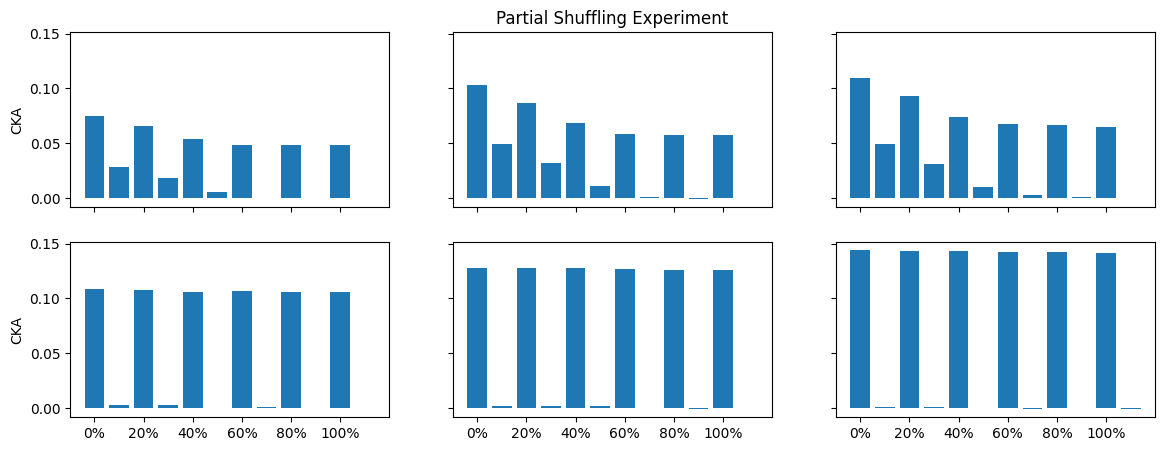

In [64]:
import matplotlib.pyplot as plt 
plt.rcParams['svg.fonttype'] = 'none'

width = 0.3
alpha_biased = 0.4
alpha_debiased = 1.0
errorbar_alpha = 0.4
offset = 0.3

alphas = [0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1]

fig, axes = plt.subplots(2,3, figsize=(14,5), sharex=True, sharey=True)

axes[0,0].bar(range(len(conv1_list_V1)), conv1_list_V1)
axes[0,1].bar(range(len(maxpool_list_V1)), maxpool_list_V1)
axes[0,2].bar(range(len(layer1_0_conv1_list_V1)), layer1_0_conv1_list_V1)

axes[1,0].bar(range(len(conv1_list_lPPA)), conv1_list_lPPA)
axes[1,1].bar(range(len(maxpool_list_lPPA)), maxpool_list_lPPA)
axes[1,2].bar(range(len(layer1_0_conv1_list_lPPA)), layer1_0_conv1_list_lPPA)

axes[0,1].set_title('Partial Shuffling Experiment')
axes[0,0].set_ylabel('CKA')
axes[1,0].set_ylabel('CKA')

axes[1,0].set_xticks([0,2,4,6,8,10])
axes[1,0].set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

plt.savefig('partial_shuffling_figure.svg', type='svg')

In [32]:
layer1_0_conv1_list_lPPA

[0.0013103224,
 0.0013103224,
 0.0005711557,
 0.0005711557,
 0.000488891,
 0.000488891,
 -0.0005176265,
 -0.0005176265,
 0.00014386939,
 0.00014386939,
 -0.0011188588,
 -0.0011188588]

<BarContainer object of 10 artists>

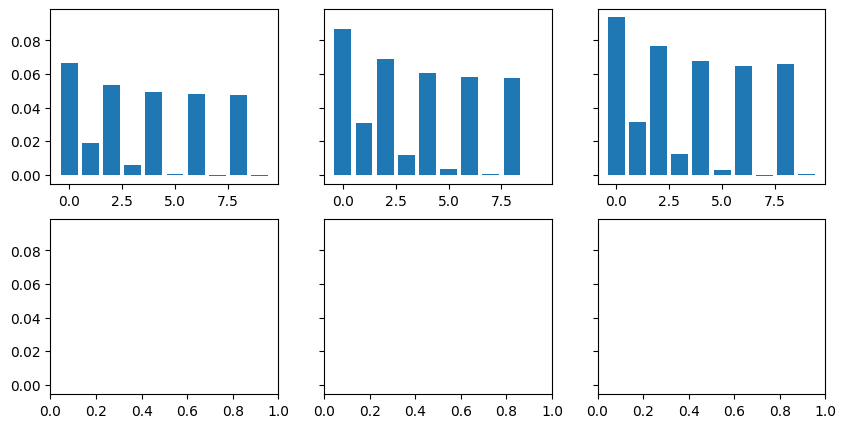

In [95]:
fig, axes = plt.subplots(2,3, figsize=(10,5), sharey=True)

axes[0,0].bar(range(len(conv1_m)), conv1_m)
axes[0,1].bar(range(len(maxpool_m)), maxpool_m)
axes[0,2].bar(range(len(layer1_0_conv1_m)), layer1_0_conv1_m)